In [34]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as func

In [2]:
spark = SparkSession.builder\
                    .appName("imaya sample")\
                    .getOrCreate()

In [9]:
london_data = spark.read\
        .format("csv")\
        .option("header", "true")\
        .load("../dataset/london_crime_by_lsoa.csv")

In [8]:
london_data.describe().show()

+-------+---------+--------------------+--------------------+-------------------+------------------+-----------------+------------------+
|summary|lsoa_code|             borough|      major_category|     minor_category|             value|             year|             month|
+-------+---------+--------------------+--------------------+-------------------+------------------+-----------------+------------------+
|  count| 13490604|            13490604|            13490604|           13490604|          13490604|         13490604|          13490604|
|   mean|     null|                null|                null|               null|0.4779443529733732|           2012.0|               6.5|
| stddev|     null|                null|                null|               null|1.7715128643049873|2.581988993167432|3.4520526574775308|
|    min|E01000001|Barking and Dagenham|            Burglary|Assault with Injury|                 0|             2008|                 1|
|    max|E01033746|         Westmi

In [13]:
london_data.count()

13490604

In [15]:
nona_london_data = london_data.dropna()

In [16]:
nona_london_data.count()

13490604

In [17]:
london_data.limit(5).show()

+---------+----------+--------------------+--------------------+-----+----+-----+
|lsoa_code|   borough|      major_category|      minor_category|value|year|month|
+---------+----------+--------------------+--------------------+-----+----+-----+
|E01001116|   Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
|E01001646| Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
|E01000677|   Bromley|Violence Against ...|      Other violence|    0|2015|    5|
|E01003774| Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|E01004563|Wandsworth|             Robbery|   Personal Property|    0|2008|    6|
+---------+----------+--------------------+--------------------+-----+----+-----+



In [21]:
london_boroughs = london_data.select('borough').distinct()
#london_boroughs.show()
london_boroughs.count()

33

In [23]:
hackney_data = london_data.filter(london_data['borough'] == 'Hackney')
#hackney_data.show()
hackney_data.count()

417744

In [27]:
london_data_2015_16 = london_data.filter(london_data['year'].isin(['2015', '2016']))
#london_data_2015_16.count()
london_data_2015_16.sample(fraction=0.1).show()

+---------+--------------------+--------------------+--------------------+-----+----+-----+
|lsoa_code|             borough|      major_category|      minor_category|value|year|month|
+---------+--------------------+--------------------+--------------------+-----+----+-----+
|E01002804|           Islington|  Theft and Handling|Theft/Taking Of M...|    0|2016|    6|
|E01002884|Kensington and Ch...|Other Notifiable ...|    Other Notifiable|    0|2016|   10|
|E01003582|              Newham|Violence Against ...|          Harassment|    0|2015|    8|
|E01000392|              Bexley|  Theft and Handling|  Other Theft Person|    0|2016|    8|
|E01004476|          Wandsworth|     Criminal Damage|Criminal Damage T...|    0|2016|   12|
|E01002701|           Islington|    Fraud or Forgery|  Counted per Victim|    0|2015|    3|
|E01001100|             Croydon|Violence Against ...|        Wounding/GBH|    0|2016|    6|
|E01002703|           Islington|  Theft and Handling|Handling Stolen G...|    0|

In [36]:
borough_conviction_sum = london_data.groupBy(['borough'])\
                                    .agg({'value':'sum'})\
                                    .withColumnRenamed('sum(value)','convictions')
#borough_conviction_sum.show(5)


In [51]:
total_burough_convictions = borough_conviction_sum.agg({'convictions':'sum'})
#returns list of Rows
total_convictions_list = total_burough_convictions.collect()
total_convictions = total_convictions_list[0][0]

In [52]:
total_convictions

6447758.0

In [44]:
borough_percentage_contribution = borough_conviction_sum.withColumn(
                        '% contribution',
                        func.round(borough_conviction_sum.convictions/total_convictions*100,2)
                        )
borough_percentage_contribution.show(5)

+--------------------+-----------+--------------+
|             borough|convictions|% contribution|
+--------------------+-----------+--------------+
|             Croydon|   260294.0|          4.04|
|          Wandsworth|   204741.0|          3.18|
|              Bexley|   114136.0|          1.77|
|             Lambeth|   292178.0|          4.53|
|Barking and Dagenham|   149447.0|          2.32|
+--------------------+-----------+--------------+
only showing top 5 rows



In [45]:
borough_percentage_contribution.printSchema()

root
 |-- borough: string (nullable = true)
 |-- convictions: double (nullable = true)
 |-- % contribution: double (nullable = true)



In [47]:
borough_percentage_contribution.orderBy(borough_percentage_contribution[2].desc()).show(10)

+-------------+-----------+--------------+
|      borough|convictions|% contribution|
+-------------+-----------+--------------+
|  Westminster|   455028.0|          7.06|
|      Lambeth|   292178.0|          4.53|
|    Southwark|   278809.0|          4.32|
|       Camden|   275147.0|          4.27|
|       Newham|   262024.0|          4.06|
|      Croydon|   260294.0|          4.04|
|       Ealing|   251562.0|           3.9|
|    Islington|   230286.0|          3.57|
|Tower Hamlets|   228613.0|          3.55|
|        Brent|   227551.0|          3.53|
+-------------+-----------+--------------+
only showing top 10 rows



In [53]:
conviction_monthly = london_data.filter(london_data['year'] == 2014)\
                            .groupBy('month') \
                            .agg({'value':'sum'})\
                            .withColumnRenamed('sum(value)', 'convictions')


DataFrame[month: string, convictions: double]

In [54]:
conviction_monthly.show(5)

+-----+-----------+
|month|convictions|
+-----+-----------+
|    7|    58564.0|
|   11|    59704.0|
|    3|    57669.0|
|    8|    55641.0|
|    5|    56327.0|
+-----+-----------+
only showing top 5 rows



In [55]:
crimes_category = london_data.groupBy('major_category')\
                        .agg({'value':'sum'})\
                        .withColumnRenamed('sum(value)', 'convictions')

In [57]:
#lazy processing. The previous cell does not do any processing
crimes_category.show(5)

+--------------------+-----------+
|      major_category|convictions|
+--------------------+-----------+
|               Drugs|   470765.0|
|             Robbery|   258873.0|
|  Theft and Handling|  2661861.0|
|    Fraud or Forgery|     5325.0|
|Violence Against ...|  1558081.0|
+--------------------+-----------+
only showing top 5 rows



In [65]:
min_year = london_data.select('year')\
            .agg({'year':'min'})
min_year.show()

+---------+
|max(year)|
+---------+
|     2016|
+---------+



In [67]:
crimes_category.orderBy(crimes_category.convictions.desc()).show(5)

+--------------------+-----------+
|      major_category|convictions|
+--------------------+-----------+
|  Theft and Handling|  2661861.0|
|Violence Against ...|  1558081.0|
|            Burglary|   754293.0|
|     Criminal Damage|   630938.0|
|               Drugs|   470765.0|
+--------------------+-----------+
only showing top 5 rows



In [69]:
london_data.crosstab('borough', 'major_category')\
            .select('borough_major_category','Burglary','Drugs','Fraud or Forgery','Robbery')\
            .show(5)

+----------------------+--------+-----+----------------+-------+
|borough_major_category|Burglary|Drugs|Fraud or Forgery|Robbery|
+----------------------+--------+-----+----------------+-------+
|              Havering|   32400|32616|            5508|  27648|
|                Merton|   26784|29160|            5724|  23652|
|              Haringey|   31320|35424|           10368|  29484|
|         Tower Hamlets|   31104|37368|            5400|  28512|
|               Bromley|   42552|42336|            8532|  34668|
+----------------------+--------+-----+----------------+-------+
only showing top 5 rows



In [70]:
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [72]:
details2014 = london_data.filter(london_data['year'] == 2014)\
                            .groupBy('borough') \
                            .agg({'value':'sum'})\
                            .withColumnRenamed('sum(value)', 'convictions')

In [73]:
details2014.show(5)

+--------------------+-----------+
|             borough|convictions|
+--------------------+-----------+
|             Croydon|    27357.0|
|          Wandsworth|    21364.0|
|              Bexley|    11844.0|
|             Lambeth|    31765.0|
|Barking and Dagenham|    15426.0|
+--------------------+-----------+
only showing top 5 rows



In [75]:
blist = [x[0]  for x in details2014.toLocalIterator()]
clist = [x[1]  for x in details2014.toLocalIterator()]

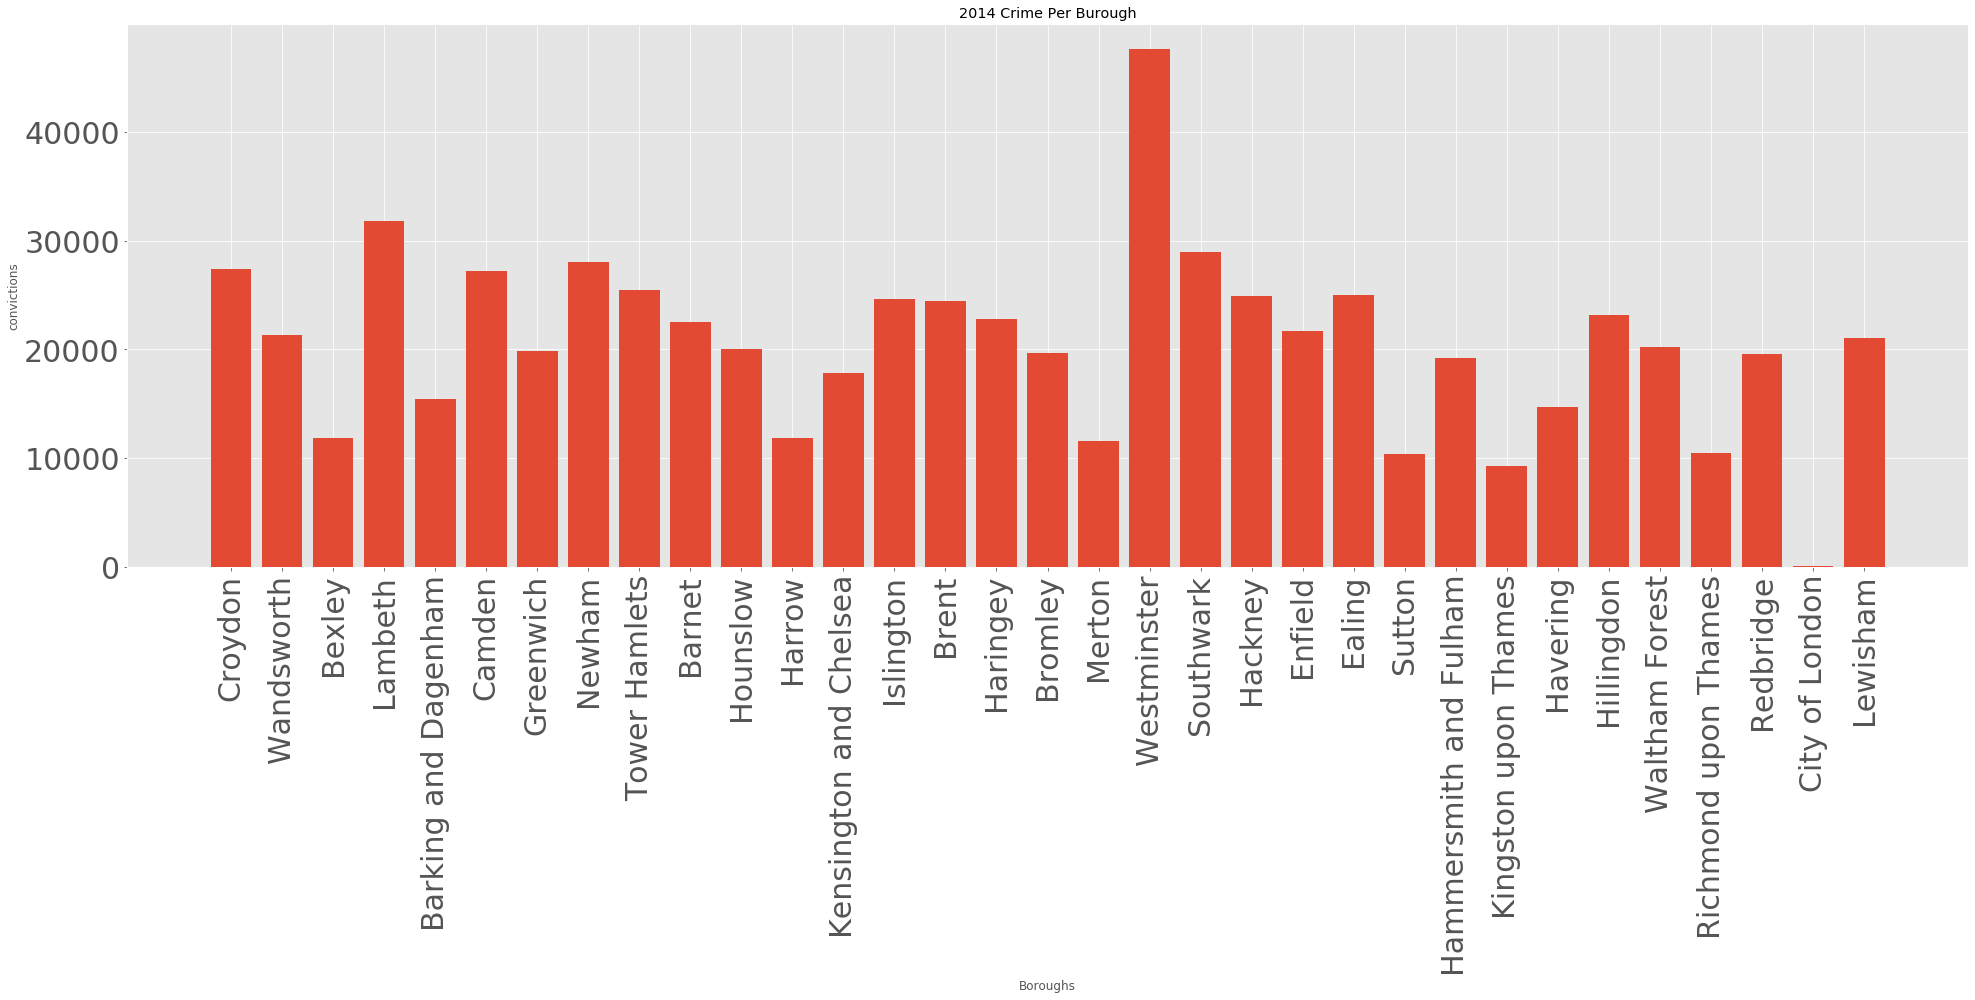

In [77]:
plt.figure(figsize=(33,10))
plt.bar(blist, clist)
plt.title("2014 Crime Per Burough")
plt.xlabel("Boroughs")
plt.ylabel("convictions")
plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=30)
plt.autoscale()
plt.show()